# Leaf Level Photosynthesis

Here, we will go one step further and look at the entire leaf-level response, including the impact of stomatal conductance as well.

## Stomatal Conductance
Before, we focussed mainly on the demand-driven constraints through Rubisco and RuBP regeneration. Stomatal conductance is highly important as it drives the suppy-side of photosynthesis and interacts with the energy balance and leaf temperature as latent heat fluxes are a major factor in surface cooling.

Before, we have derived net rates of photosynthesis $A_n$, which have to be matched with the supply side through CO$_2$ diffusion:

$$A_n^{diff} = g_{leaf,C}(C_a-C_c)$$

which can be separated into diffusion from the air to the leaf surface with a boundary layer conductance $g_{b,C}$, diffusion from the surface to the interstitial air-space with stomatal conductance $g_{s,C}$ and diffusion from the  interstitial air-space to the chloroplast with mesophyll conductance $g_{m,C}$ (the letter C stands for CO2 here, as the diffusion constants vary with species, e.g. H$_2$O stomatal conductance is a factor 1.6 higher than those for CO$_2$):

$$A_n^{diff} = g_{b,C}(C_a-C_s) = g_{s,C}(C_s-C_i) = g_{m,C}(C_i-C_c) = g_{leaf,C}(C_a-C_c)$$

$$g_{leaf,C} = \left(\frac{1}{g_{b,C}+g_{s,C}+g_{m,C}}\right)^{-1}$$

The importance of stomatal conductance and its interplay with photosynthesis here is that the supply and demand rates determine $C_c$. A reduction in $C_c$ reduces the demand-limited rates while it increase the diffusion rates (at a given $g$). Most models run internal so-called A-$C_c$ iterations to ensure both rates are balanced and in steady-state ($\partial C_c/\partial t=0$). We implement this option but also opt to run stomatal conductance prognostically, as stomata don't open and close instantanously but have a response time of around 15 minutes.

### Empirical Stomatal Conductance models

Currently, we can choose between the widely used Ball-Berry model[^1] or the Medlyn approach[^2].

Ball and Berry derived the following empirical formulation based on leaf level data (RH is relative humidity):

$$g_{s,w} = g_0 + g_1  \frac{A_n \cdot RH}{C_s}$$

Medlyn derived the following equations based on stomatal optimization theory but in a similar form as the BB model:

$$g_{s,w} = g_0 + \left(1 + \frac{g_1}{\sqrt{VPD}}\right) \frac{A_n}{C_s}$$

Both models are proportional to $A_n$ and inversely proportional to $C_s$, with the main difference in the dependence on either relative humidity in the Ball-Berry model vs. vapor pressure deficit (VPD) in Medlyn et al. In both cases, $g_0$ is the residual conductivity even if stomata are fully closed and $g_1$ is related to the marginal water cost of plant carbon gain. Importantly, $g_1$ can't be inter-changed between the formulations, underlining again that parameters have to be optimized with respect to the model that is eventually being used.

### Stomatal Optimization Theories

The empirical formulations only hold in well-watered soil and our main goal is to implement stomatal optimization models to take the entire soil-plant-atmosphere continuum into account[^3]. Here, we will just use the empirical models and steady-state photosynthesis to show the underlying principles.

[^1]: Ball, J.T., Woodrow, I.E. and Berry, J.A., 1987. A model predicting stomatal conductance and its contribution to the control of photosynthesis under different environmental conditions. In Progress in photosynthesis research (pp. 221-224). Springer, Dordrecht.

[^2]: Medlyn, B.E., Duursma, R.A., Eamus, D., Ellsworth, D.S., Prentice, I.C., Barton, C.V., Crous, K.Y., De Angelis, P., Freeman, M. and Wingate, L., 2011. Reconciling the optimal and empirical approaches to modelling stomatal conductance. Global Change Biology, 17(6), pp.2134-2144.

[^3]: Wang, Y., Sperry, J.S., Anderegg, W.R., Venturas, M.D. and Trugman, A.T., 2020. A theoretical and empirical assessment of stomatal optimization modeling. New Phytologist.

In [1]:
# Add usual tools we use:
##using Revise
using BenchmarkTools
using PyPlot

In [2]:
# load Photosynthesis module:
using Land.Photosynthesis

In [3]:
# Specify Field Type
const FT = Float64

Float64

In [4]:
# Create a standard leaf with defualt parameters
leaf3 = Leaf{FT}(APAR=1200, Vcmax25=90, Jmax25=90*1.9, Vpmax25=100, Rd25=1);
leaf4 = Leaf{FT}(APAR=1200, Vcmax25=90, Jmax25=90*1.9, Vpmax25=100, Rd25=1);
# Create a standard meteo structure:
envir  = AirLayer{FT}();

In [5]:
# Setting some standard values (dynamic-state=false forces A-Cc iterations)
##leaf.dynamic_state = false

---
## Modular stucture:
The most important step is to define which submodules to use. There might be different implementations for Fluorescence, Photosynthesis (C3,C4,etc), respiration, stomatal conductance (e.g. Ball-Berry, Medlyn), the T-dependence of J$_{max}$, V$_{c,max}$ and Michaelis Menten constants as well as leaf boundary layer resistance (setting it to 0 here to mimic well vented laboratory leaf level measurements) and colimitation.

Below, we create two different model setups with a C3 and C4 photosynthesis pathway. Note that we chose the Ball Berry stomatal conductance model with different $g_1$ for C3 and C4 (C4 typically much lower).

In [6]:
# use this as the boundary layer resistance (1/gb)
# deprecated as there are g_bw and g_bc terms in Leaf struct
# ra = FT(0.5)

# C3 Photosynthesis

Use pre-defined parameter sets

In [7]:
modC3 = C3CLM(FT)
modC3.Col = Photosynthesis.CurvedColimit{FT}();
modC3.Sto = Photosynthesis.ESMBallBerry{FT}(g1 = 16)

# C4 Photosynthesis
modC4 = C4CLM(FT)
modC4.Col = Photosynthesis.CurvedColimit{FT}();
modC4.Sto = Photosynthesis.ESMBallBerry{FT}(g1 = 8)

Land.Photosynthesis.ESMBallBerry{Float64}(0.025, 8.0)

## Light response curves
Now we can compute light response curves for C3 and C4 photosynthesis

In [8]:
##Again, this looks tedious and repetitive but is the easiest way to do this right now:

# Variable I want to save:
Ag_C3 = Float32[]; Ag_C4 = Float32[];
An_C3 = Float32[]; An_C4 = Float32[];
Aj_C3 = Float32[]; Aj_C4 = Float32[];
Ap_C3 = Float32[]; Ap_C4 = Float32[];
Ac_C3 = Float32[]; Ac_C4 = Float32[];
Cc_C3 = Float32[]; Cc_C4 = Float32[];
gs_C3 = Float32[]; gs_C4 = Float32[];

APAR = collect(FT, 0:10:1700)
for _APAR in APAR
    leaf3.APAR = _APAR;
    leaf4.APAR = _APAR;
    # Run C3 photosynthesis (general photosynthesis model):
    leaf_photo_from_envir!(modC3, leaf3, envir, modC3.Sto);
    # Save leaf variables:
    push!(An_C3, leaf3.An); push!(Ag_C3, leaf3.Ag);
    push!(Aj_C3, leaf3.Aj); push!(Ap_C3, leaf3.Ap);
    push!(Ac_C3, leaf3.Ac); push!(Cc_C3, leaf3.p_i);
    push!(gs_C3, leaf3.g_sw);

    # Run C4 photosynthesis:
    leaf_photo_from_envir!(modC4, leaf4, envir, modC4.Sto);
    # Save leaf variables:
    push!(An_C4, leaf4.An); push!(Ag_C4, leaf4.Ag);
    push!(Aj_C4, leaf4.Aj); push!(Ap_C4, leaf4.Ap);
    push!(Ac_C4, leaf4.Ac); push!(Cc_C4, leaf4.p_i);
    push!(gs_C4, leaf4.g_sw);
end

In [9]:
# Testing some times, how long does this take (as we need to run it globally, it has to be efficient)?
# Slow for now, because of unnecessary allocations
# Will improve when the structs are cleaned up
#@btime leaf_photo_from_envir!(modC3, leaf3, envir, modC3.Sto);
#@btime leaf_photo_from_envir!(modC4, leaf4, envir, modC4.Sto);

## C3 Light Response Curve

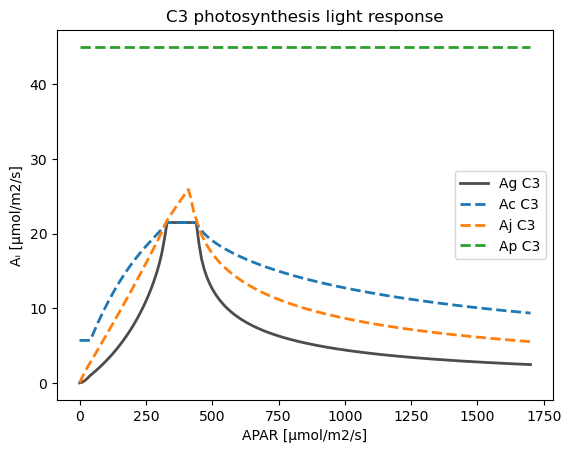

In [10]:
##plot(APAR, An,  label="An")
figure()
plot(APAR, Ag_C3,color=:black,lw=2, alpha=0.7, label="Ag C3")
plot(APAR, Ac_C3, ls="--", lw=2, label="Ac C3")
plot(APAR, Aj_C3, ls="--", lw=2, label="Aj C3")
plot(APAR, Ap_C3, ls="--", lw=2, label="Ap C3" )
xlabel("APAR [μmol/m2/s]")
ylabel("Aᵢ [μmol/m2/s]")
title("C3 photosynthesis light response")
legend()
gcf()

## C4 Light Response Curve

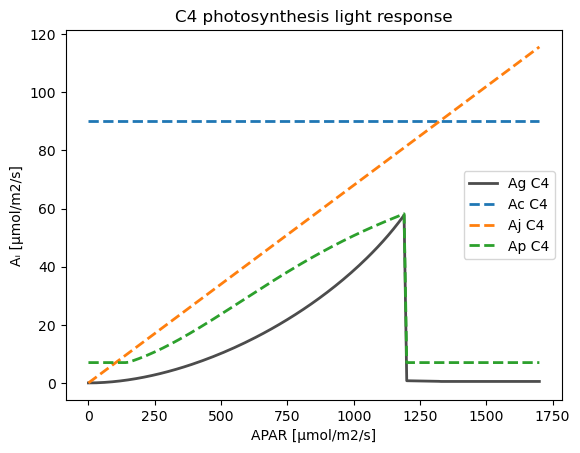

In [11]:
##plot(APAR, An,  label="An")
figure()
plot(APAR, Ag_C4,color=:black, lw=2, alpha=0.7, label="Ag C4")
plot(APAR, Ac_C4, ls="--", lw=2, label="Ac C4")
plot(APAR, Aj_C4, ls="--", lw=2, label="Aj C4")
plot(APAR, Ap_C4, ls="--", lw=2, label="Ap C4" )
xlabel("APAR [μmol/m2/s]")
ylabel("Aᵢ [μmol/m2/s]")
title("C4 photosynthesis light response")
legend()
gcf()

### Dependence of $C_c$ on light
Increasing light should result in overall lower $C_c$ concentrations. C4 plants can work with much lower $C_c$ as for C4, the concentration in the bundle sheath cells count, not the mesophyll.

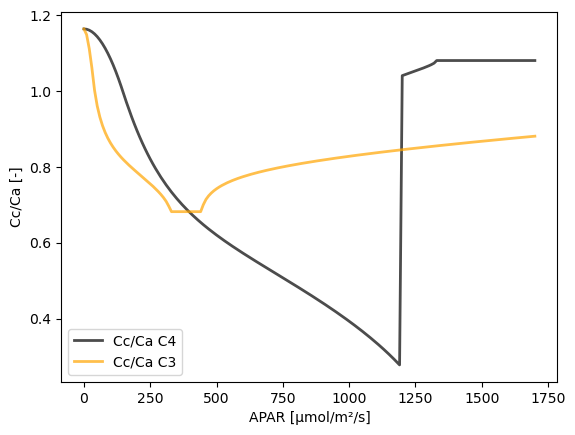

In [12]:
figure()
plot(APAR, Cc_C4/envir.p_a,color=:black ,lw=2, alpha=0.7, label="Cc/Ca C4")
plot(APAR, Cc_C3/envir.p_a,color=:orange,lw=2, alpha=0.7, label="Cc/Ca C3")
xlabel("APAR [μmol/m²/s]")
ylabel("Cc/Ca [-]")
legend()
gcf()

### Dependence of stomatal coductance g$_s$

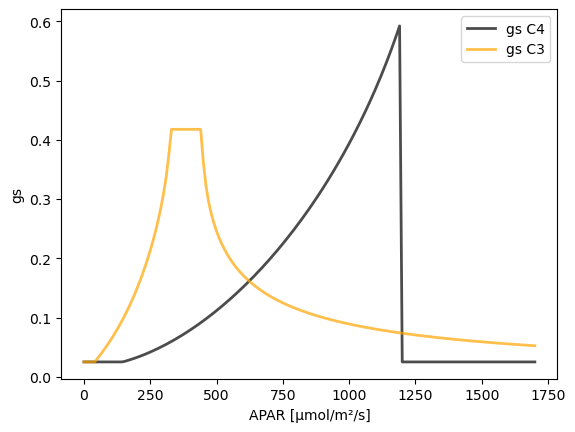

In [13]:
#This part has been broken by Yuije, please fix it
figure()
plot(APAR, gs_C4,color=:black ,lw=2, alpha=0.7, label="gs C4")
plot(APAR, gs_C3,color=:orange,lw=2, alpha=0.7, label="gs C3")
xlabel("APAR [μmol/m²/s]")
ylabel("gs")
legend()
gcf()

## More complex examples:

In [14]:
##Again, this looks tedious and repetitive but is the easiest way to do this right now:

# Now I want to vary T, APAR and CO2:
# Start CO2 from 100 ppm to make sure it is higher than Γ*
APAR = [100.0, 250.0, 500.0, 1000.0, 1500.0]
CO2  = collect(100:20:800)
T    = collect(274:2:310)

n1 = length(APAR);
n2 = length(CO2);
n3 = length(T);

Ag_C3 = zeros(n1,n2,n3); Ag_C4 = zeros(n1,n2,n3);
An_C3 = zeros(n1,n2,n3); An_C4 = zeros(n1,n2,n3);
Aj_C3 = zeros(n1,n2,n3); Aj_C4 = zeros(n1,n2,n3);
Ap_C3 = zeros(n1,n2,n3); Ap_C4 = zeros(n1,n2,n3);
Ac_C3 = zeros(n1,n2,n3); Ac_C4 = zeros(n1,n2,n3);
Cc_C3 = zeros(n1,n2,n3); Cc_C4 = zeros(n1,n2,n3);
gs_C3 = zeros(n1,n2,n3); gs_C4 = zeros(n1,n2,n3);

In [15]:
# Run this over all potential 3D dimensions:

# I really like the compact form of nested loops in Julia!
for iA in eachindex(APAR), iC in eachindex(CO2), iT in eachindex(T)
    #println(iA, "/", iC, "/", iT)
    envir.p_a  = CO2[iC]/10;
    leaf3.T    = T[iT];
    leaf3.APAR = APAR[iA];
    leaf4.T    = T[iT];
    leaf4.APAR = APAR[iA];

    # Run C3 photosynthesis:
    leaf_photo_from_envir!(modC3, leaf3, envir, modC3.Sto);

    # Save leaf variables:
    An_C3[iA,iC,iT]=leaf3.An;
    Ag_C3[iA,iC,iT]=leaf3.Ag;
    Aj_C3[iA,iC,iT]=leaf3.Aj;
    Ap_C3[iA,iC,iT]=leaf3.Ap;
    Ac_C3[iA,iC,iT]=leaf3.Ac;
    Cc_C3[iA,iC,iT]=leaf3.p_i;
    gs_C3[iA,iC,iT]=leaf3.g_sw;

    # Run C4 photosynthesis:
    leaf_photo_from_envir!(modC4, leaf4, envir, modC4.Sto);

    # Save leaf variables:
    An_C4[iA,iC,iT]=leaf4.An;
    Ag_C4[iA,iC,iT]=leaf4.Ag;
    Aj_C4[iA,iC,iT]=leaf4.Aj;
    Ap_C4[iA,iC,iT]=leaf4.Ap;
    Ac_C4[iA,iC,iT]=leaf4.Ac;
    Cc_C4[iA,iC,iT]=leaf4.p_i;
    gs_C4[iA,iC,iT]=leaf4.g_sw;
end

#### Plotting 2D contours of A$_n$ vs. CO$_2$ and Temperature

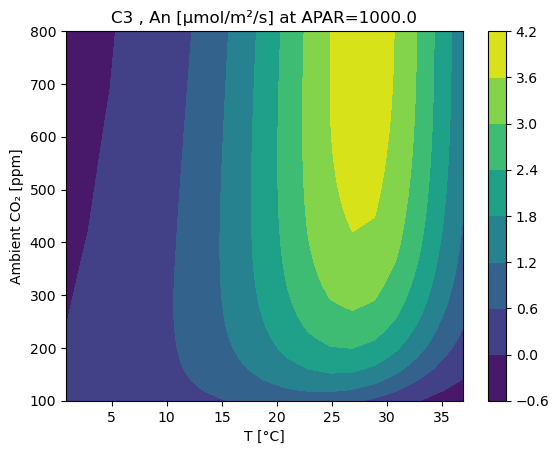

In [16]:
##Let's take one slice in APAR space:
i = 4

# and plot:
figure()
contourf(T.-273.15, CO2, An_C3[i,:,:])
xlabel("T [°C]")
ylabel("Ambient CO₂ [ppm]")
title("C3 , An [μmol/m²/s] at APAR=$(APAR[i])")
colorbar()
gcf()

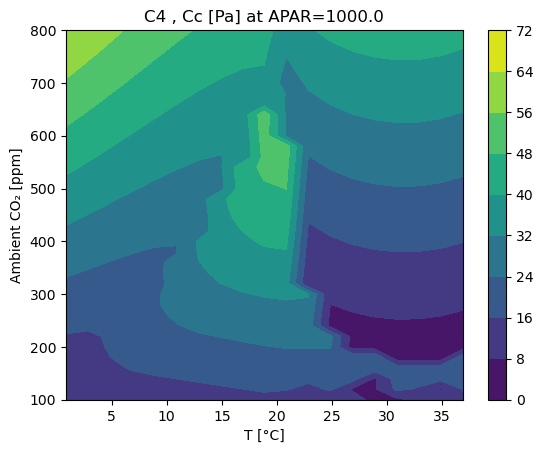

In [17]:
# Same for C4 plants, why is it so different??

figure()
contourf(T.-273.15, CO2, Cc_C4[i,:,:])
xlabel("T [°C]")
ylabel("Ambient CO₂ [ppm]")
title("C4 , Cc [Pa] at APAR=$(APAR[i])")
colorbar()
gcf()

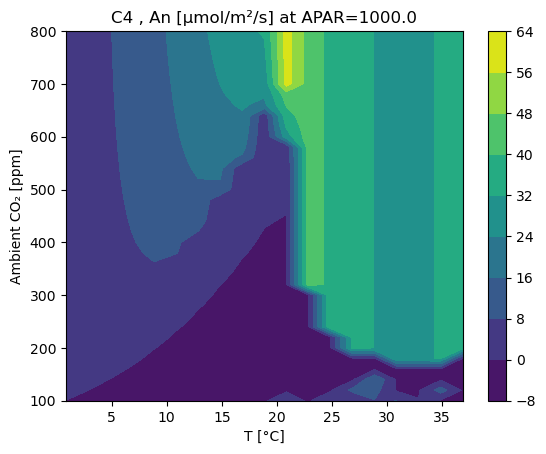

In [18]:
# Same for C4 plants, why is it so different??

figure()
contourf(T.-273.15, CO2, An_C4[i,:,:])
xlabel("T [°C]")
ylabel("Ambient CO₂ [ppm]")
title("C4 , An [μmol/m²/s] at APAR=$(APAR[i])")
colorbar()
gcf()

## Ambient CO$_2$ response curves and limiting rates for C3 and C4

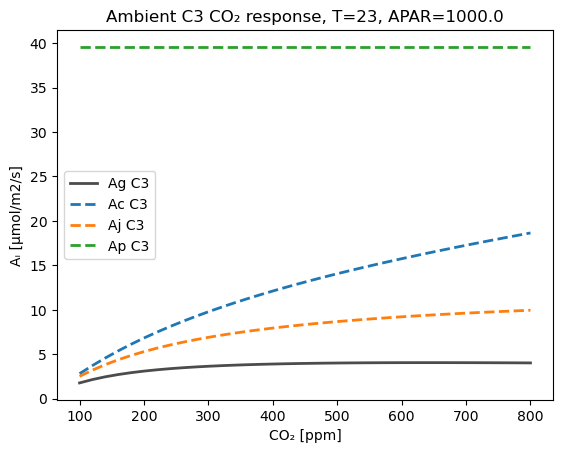

In [19]:
iA = 4; iT=12
figure()
plot( CO2, Ag_C3[iA,:,iT],color=:black,lw=2, alpha=0.7, label="Ag C3")
plot(CO2, Ac_C3[iA,:,iT], ls="--", lw=2, label="Ac C3")
plot(CO2, Aj_C3[iA,:,iT], ls="--", lw=2, label="Aj C3")
plot(CO2, Ap_C3[iA,:,iT], ls="--", lw=2, label="Ap C3" )
xlabel("CO₂ [ppm]")
ylabel("Aᵢ [μmol/m2/s]")
title("Ambient C3 CO₂ response, T=$(T[iT]-273), APAR=$(APAR[iA])")
legend()
gcf()

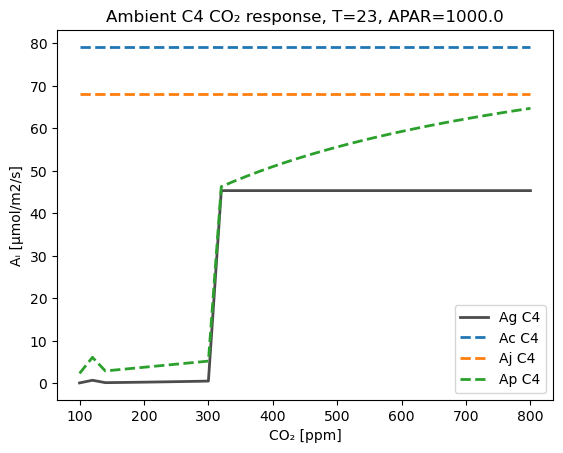

In [20]:
iA = 4; iT=12
figure()
plot(CO2, Ag_C4[iA,:,iT],color=:black,lw=2, alpha=0.7, label="Ag C4")
plot(CO2, Ac_C4[iA,:,iT], ls="--", lw=2, label="Ac C4")
plot(CO2, Aj_C4[iA,:,iT], ls="--", lw=2, label="Aj C4")
plot(CO2, Ap_C4[iA,:,iT], ls="--", lw=2, label="Ap C4")
xlabel("CO₂ [ppm]")
ylabel("Aᵢ [μmol/m2/s]")
title("Ambient C4 CO₂ response, T=$(T[iT]-273), APAR=$(APAR[iA])")
legend()
gcf()

---
## Summary:
Play around a bit with different parameters. You can also try to change humidity at the leaf level or the boundary layer resistance. There are ## many things that can be tested, and we often like to go to the extremes (T, CO$_2$, ra) to check for bugs, which most often have to do with the ## A-C$_c$ iterations.

Note of caution: we really plotted CO$_2$ response curves against ambient CO$_2$. At low C$_c$, leaves can be a source of CO$_2$ due to the CO$_2$ compensation point (i.e. A$_g$ can be negative!). Also, at CO$_2$=0, stomatal conductance using the empirical formulation goes to $\infty$, which can cause unwanted behavior.

Test things out, learn by changing parameters and try to break it!

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*